# Machine Translation

English-German Translation

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 


Using TensorFlow backend.


# 2)- Reading Dataset

In [0]:
# function to read raw text file
def read_text(filename): 
        # open the file 
        file = open(filename, mode='rt', encoding='utf-8') 
        
        # read all text 
        text = file.read() 
        file.close() 
        return text

In [0]:
# split text into sentences 
def to_lines(text): 
      sents = text.strip().split('\n') 
      sents = [i.split('\t') for i in sents] 
      return sents

In [0]:
data = read_text("full_data_clean.txt") 
deu_eng = to_lines(data) 
deu_eng = array(deu_eng)

# 3)-Text Pre-Processing

In [0]:
df= pd.read_pickle('full_data.pkl')

In [42]:
df.head(2)

,eng,ger
0,Prague Stock Market falls to minus by the end of the trading day,Die Prager Börse stürzt gegen Geschäftsschluss ins Minus.
1,After a sharp drop in the morning,Nach dem steilen Abfall am Morgen konnte die Prager Börse die Verluste korrigieren.


In [43]:
df.shape

(22191, 2)

In [0]:
df_random=df.sample(5000)

In [45]:
df_random.head(10)

,eng,ger
7698,"Lastly, they place in a glaring light the way in which the French presidency tried to manipulate the media to give credence of the idea that the Syrian president, Bachar Al-Assad played a central ...","Schließlich setzen sie die Art und Weise, mit der das französische Präsidium die Medien zu dem Zwecke zu manipulieren versucht hat, diesen die Idee glaubhaft zu machen, der syrische Präsident Bach..."
7830,An important bonds manager said yesterday that the Bank must at all costs offsat the shortage of investors in the market and prevent a boom of payments by the most vulnerable States.,"""Sie muss zu jedem Preis an die Steller der mangelnden Investoren auf dem Markt treten und derart handeln, um die vorschnelle Begeisterung über die an die schwächsten Staaten gezahlten Renditen zu..."
20876,"Breit got her interest in fashion from her mother, when she was still in the cradle.",Ihr Mode-Interesse hat Breit von ihrer Mutter in die Wiege gelegt bekommen.
717,It was the biggest one-day point-drop in its history.,Das war der größte Punkteverlust innerhalb eines Tages in seiner Geschichte.
4896,"The white club has been the third on the continent to have pocketed more money from participating, and the only one, after AC Milan, to have won the trophy three times.","Der weiβe Club liegt an dritter Stelle Europas, der am meisten Geld durch seine Teilnahme verdient hat und der neben dem AC Mailand der einzige, der dreimal die Trophäe gewonnen hat."
2708,"Traditionally, the most highly-anticipated award, the Nobel Peace Prize, went to the American president Barack Obama in the Norwegian city of Oslo this afternoon.","Traditionsgemäß hat der amerikanische Präsident, Barak Obama, den am meisten erwarteten Friedennobelpreis schon heute nachmittag in Oslo erhalten."
4813,"What is logical is that Ecofin has forced the Greek government to be transparent, and make its citizens jointly responsible for the need for extraordinary measures to maintain the stability of its...","Dagegen ist es logisch, dass Ecofin die griechische Regierung dazu gezwungen hat, transparent zu sein und seine Bürger bei der Notwendigkeit von auβergewöhnlicchen Maβnahmen mit in die Pflicht zu ..."
19270,Michael J. Fox Jokes About His 'Date' With Princess Diana,"Michael J. Fox scherzt über sein ""Date"" mit Prinzessin Diana"
14903,Basketball: Hopes are growing for the Neckar Riesen (Neckar Giants).,Basketball: Die Hoffnung der Neckar Riesen wächst
11292,He's worked with great players.,Er hatte Kontakt mit großen Spielern.


In [0]:
deu_eng=df_random.values

In [47]:
type(deu_eng)

numpy.ndarray

In [48]:
deu_eng[0]

array(['Lastly, they place in a glaring light the way in which the French presidency tried to manipulate the media to give credence of the idea that the Syrian president, Bachar Al-Assad played a central part in the release of Clotilde Reiss.',
       'Schließlich setzen sie die Art und Weise, mit der das französische Präsidium die Medien zu dem Zwecke zu manipulieren versucht hat, diesen die Idee glaubhaft zu machen, der syrische Präsident Bachar Al-Assad habe eine zentrale Rolle bei der Befreiung von Clotilde Reiss gespielt, in ein grelles Licht.'],
      dtype=object)

In [49]:
# for english part 
deu_eng[:,0]

array(['Lastly, they place in a glaring light the way in which the French presidency tried to manipulate the media to give credence of the idea that the Syrian president, Bachar Al-Assad played a central part in the release of Clotilde Reiss.',
       'An important bonds manager said yesterday that the Bank must at all costs offsat the shortage of investors in the market and prevent a boom of payments by the most vulnerable States.',
       'Breit got her interest in fashion from her mother, when she was still in the cradle.',
       ..., 'All a nonsense', 'This we know.',
       '"All wins are fun, no matter how it happens," Tigers manager Brad Ausmus said.'],
      dtype=object)

In [50]:
# for german part of lang.
deu_eng[:,1]

array(['Schließlich setzen sie die Art und Weise, mit der das französische Präsidium die Medien zu dem Zwecke zu manipulieren versucht hat, diesen die Idee glaubhaft zu machen, der syrische Präsident Bachar Al-Assad habe eine zentrale Rolle bei der Befreiung von Clotilde Reiss gespielt, in ein grelles Licht.',
       '"Sie muss zu jedem Preis an die Steller der mangelnden Investoren auf dem Markt treten und derart handeln, um die vorschnelle Begeisterung über die an die schwächsten Staaten gezahlten Renditen zu verhindern", bezeugte gestern ein wichtiger Obligationeninhaber.',
       'Ihr Mode-Interesse hat Breit von ihrer Mutter in die Wiege gelegt bekommen.',
       ..., 'Natürlich ist das eine Menge Unsinn', 'Das wissen wir.',
       '"Alle Siege machen Spaß, egal wie es kommt", sagte Tigers Manager Brad Ausmus.'],
      dtype=object)

### 3.1)-Text cleaning

In [0]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]] 
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]] 

# convert text to lowercase 
for i in range(len(deu_eng)): 
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

### 3.2)-Text to Sequence Conversion

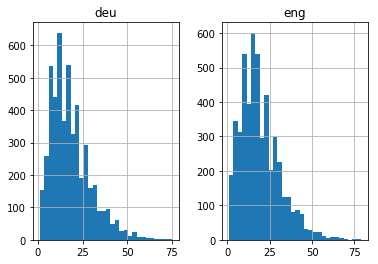

In [52]:
# empty lists 
eng_l = [] 
deu_l = [] 

# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
      eng_l.append(len(i.split())) 

for i in deu_eng[:,1]: 
      deu_l.append(len(i.split())) 

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30) 
plt.show()

the maximum length of the German sentences is 78 and that of the English phrases is 75.

### 3.3)-vectorize our text data 

by using Keras’s Tokenizer()

In [53]:
# function to build a tokenizer 
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 8 

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 14491


In [54]:
# prepare Deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[:, 1]) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 8 
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 20662


There is difference in amount of words in two languages.We need to encode sequence

### 3.4)-encode and pad sequences 

In [0]:
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

# 4)-Model Building

### 4.1)- Train-test Split

80%-20%

In [0]:
from sklearn.model_selection import train_test_split 

# split data into train and test set 
train,test= train_test_split(deu_eng,test_size=0.2,random_state= 12)

### 4.2)- Defining input and target
We will encode English sentences as the input sequences and German sentences as the target sequences

In [57]:
# english version
train[:, 0]

array(['it is issued to him and given through the fence',
       'when choosing the size of your mattress thickness add one foot length to your height which is about 2134 cm',
       'a good portion of the store is given over to the massive freezer section where youll find frozen curry leaves bitter melon and galangal whole ducks fish beef blood and bile pork casings fish balls regional sausages commerciallyprepared foods and more',
       ...,
       'ruins measuring five metres tall made from stones around the size of the palm of your hand are waiting to be discovered',
       'the latters order is likely to have been a similar one get me goal number two',
       'fiftyone percent of those surveyed are against cooperating with the syrian ruler bashar alassad but 20 percent were in favour'],
      dtype=object)

In [58]:
# english version
train[:, 1]

array(['die waffe wird ausgestellt und durch den zaun übergeben',
       'bei der wahl der matratzengröße sollte man zur körpergröße immer noch die länge der fußsohlen hinzurechnen also ca 21 bis 34 cm',
       'ein guter teil des ladens gehört der massiven gefrierabteilung hier finden sie gefrorene curryblätter bittere melone und galgant ganze enten fisch rinderblut und galle schweinenaturdarm fischbällchen regionale wurst kommerziell zubereitete lebensmittel und mehr',
       ...,
       'zu sehen sind etwa fünf meter hohe ruinen aus handtellergroßen steinen',
       'dessen befehl wird ähnlich gelautet haben her mit tor zwei',
       'eine zusammenarbeit mit dem syrischen machthaber baschar alassad lehnen 51 prozent der befragten ab 20 prozent wären dafür'],
      dtype=object)

In [0]:
# prepare training data 
trainX = encode_sequences(eng_tokenizer, deu_length, train[:, 0]) 
trainY = encode_sequences(deu_tokenizer, eng_length, train[:, 1]) 

# prepare validation data 
testX = encode_sequences(eng_tokenizer, deu_length, test[:, 0]) 
testY = encode_sequences(deu_tokenizer, eng_length, test[:, 1])

In [60]:
print(trainX[:5])

[[  941     3    79     5   269   129     1  1618]
 [    3    97  2447    30     7    47 14294 14295]
 [ 1588 12943   623 12944 12945  5797     5    41]
 [ 2617    49   735  3318    18    70   944  4481]
 [    5   145  6017  2479    15    44  2138  1432]]


In [61]:
print(trainY[:5])

[[ 2832    37  2641     3    61     7  4001  6411]
 [20291 20292   186   659   631    63  2979  3364]
 [17929  3620  6354 17930 17931  1905     3    56]
 [   20     5   245  1075   708  4149   131    44]
 [13752    50   440 13753    38   177  1629  1362]]


In [62]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(4000, 8)
(4000, 8)
(1000, 8)
(1000, 8)


### 4.3)- build NMT model

In [63]:
eng_length

8

In [64]:
deu_length

8

In [0]:
 def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, n, input_length=in_timesteps,   
      mask_zero=True)) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

In [0]:
# model compilation (with 512 hidden units)
model = build_model(eng_vocab_size,deu_vocab_size, eng_length, deu_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [67]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 8, 512)            7419392   
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_2 (Dense)              (None, 8, 20662)          10599606  
Total params: 22,217,398
Trainable params: 22,217,398
Non-trainable params: 0
_________________________________________________________________


In [68]:
filename = 'model_translate.h1' 

# set checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 


# train model 
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)

Train on 3200 samples, validate on 800 samples
Epoch 1/30
3200/3200 [==============================] - 5s 2ms/step - loss: 9.2146 - val_loss: 8.1807

Epoch 00001: val_loss improved from inf to 8.18068, saving model to model_translate.h1
Epoch 2/30
3200/3200 [==============================] - 3s 918us/step - loss: 7.6958 - val_loss: 8.3215

Epoch 00002: val_loss did not improve from 8.18068
Epoch 3/30
3200/3200 [==============================] - 3s 921us/step - loss: 7.4887 - val_loss: 8.4361

Epoch 00003: val_loss did not improve from 8.18068
Epoch 4/30
3200/3200 [==============================] - 3s 926us/step - loss: 7.3985 - val_loss: 8.5338

Epoch 00004: val_loss did not improve from 8.18068
Epoch 5/30
3200/3200 [==============================] - 3s 926us/step - loss: 7.3715 - val_loss: 8.6195

Epoch 00005: val_loss did not improve from 8.18068
Epoch 6/30
3200/3200 [==============================] - 3s 917us/step - loss: 7.3057 - val_loss: 8.8273

Epoch 00006: val_loss did not impr

# 5)-Plotting results

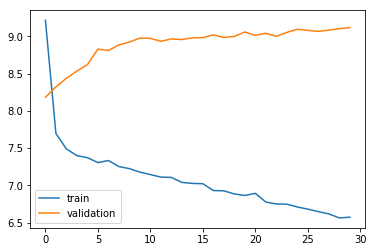

In [69]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

As you can see in the above plot, the validation loss stopped decreasing after 25 epochs. It did improve but not very significant.

# 6)-Make Predictions

In [0]:
model = load_model('model_translate.h1') 

preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

These predictions are sequences of integers. We need to convert these integers to their corresponding words.

### 6.1)- Convert integers to words

In [0]:
def get_word(n, tokenizer):  
      for word, index in tokenizer.word_index.items():                       
          if index == n: 
              return word 
      return None

### 6.2)-Convert predictions into text (German)

In [0]:
preds_text = [] 
for i in preds:        
       temp = []        
       for j in range(len(i)):             
            t = get_word(i[j], deu_tokenizer)             
            if j > 0:                 
                if (t==get_word(i[j-1],deu_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [75]:
# 1st 15 rows
pred_df.head(5)

,actual,predicted
0,für eure costaricanischen fans verwirklicht sich ein traum wenn pearl jam in costa rica spielt seid ihr euch bewusst was das für eure fans bedeutet,
1,jemand außerhalb des internets handelt mit respekt sittlichkeit und anderen prinzipien und dasselbe muss für die sozialen netzwerke gelten erklärt er,
2,auch promotionchef tobias hagen seit der ersten hr4radtour 2004 als tourleiter dabei konnte nur kurz verschnaufen hatte er doch reichlich mit der technik vor ort zu tun,
3,nach dem sturz des diktators saßen bis zu 11000 zivilisten in militärhaft,
4,während zehntausende von menschen weiterhin in den schutzräumen leben und die kämpfe andauern verschoben die bildungsbehörden vergangene woche den beginn des schuljahres,


In [76]:
# print 15 rows randomly 
pred_df.sample(5)

,actual,predicted
97,der black friday dauerte in seinen laden von 8 uhr abends am donnerstag bis mitternacht den nächsten tag und in diesem zeitraum verkaufte walmart ungefähr 5000 artikel pro sekunde,
661,seit 2001 stand das gebäude leer und kam mehr und mehr herunter,
200,bei ihrer argumentation gegen das urteil sagten vertreter des staates louisiana dass sie keine ärzte wegen der durchführung von abtreibungen bestrafen würden während deren anträge auf patientenein...,
197,vergewaltiger in südafrika zweimal lebenslange haft,
251,anlässlich des weltweiten tags der diabetes erklärte er es werde angestrebt dass dreitausend kinder und jugendliche im alter von sechs bis 14 jahren mit dem einverständnis und unter aufsicht ihrer...,
